<a href="https://www.kaggle.com/code/daiqing2009/effective-and-efficient-intrusion-detection?scriptVersionId=224903861" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/daiqing2009/effective-and-efficient-intrusion-detection?scriptVersionId=211743249" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/daiqing2009/CP640/blob/main/project/code/EE_intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents
The goal of this project to measure the effectiveness of common machine learning techniques in differentiating malicious traffic from benign one and identifying corresponding attacks categories and sub-categories. Meanwhile, the project will challenge the requirement to detect the intrusion traffic efficiently as required in real-world situations, especially how models trained on small data perform on larger data.
* Effective Machine Learning
    * Import isproportional Data sampling
    * EDA & Preprocessing
    * Model Selection and Evaluation
* Efficient Machine Learning
    * Model performance on different scale of sampling data
    * Potential integration with IPS(Intrusion Prevention System)


# Effective Machine Learning
In this section, dataaset will be imported. Then Exploratory Data Analysis(EDA) and corresponding preprocessing will conducted before model training and evaluation.

In [1]:
import sklearn as sk
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
# for lib in [pd, sk, sns, sv, optuna, tf, keras]:
for lib in [pd, sk, sns]:
    print(f"Using {lib.__name__} {lib.__version__}")

# define the thresthold for proprocessors
VAR_THR = 0.025
CORR_THR = 0.93

Using pandas 2.2.2
Using sklearn 1.2.2
Using seaborn 0.12.2


## Importing Data
The importing subsection try to be competible in all environments, including Colab, Kaggle and local dev. The original dataset is on https://www.kaggle.com/datasets/daiqing2009/ciciot2023-disprop-sampling

In [2]:
import os

def detect_environment():
    """Detects the environment: Kaggle, Google Colab, or Local."""
    if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
        return "Kaggle"
    elif "COLAB_GPU" in os.environ:
        return "Google Colab"
    else:
        return "Local"

def create_folder_if_not_exists(path):
    """Creates a folder if it does not already exist."""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Folder created at: {path}")
    else:
        print(f"Folder already exists at: {path}")

def setup_kaggle_credentials():
    """Ensures Kaggle API credentials are available."""
    if detect_environment() == "Google Colab":
      from google.colab import userdata
      os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
      os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    elif detect_environment() == "Local":
      kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
      if not os.path.exists(kaggle_json_path):
        # Prompt user to upload `kaggle.json`
        print("Please upload your `kaggle.json` file.")
        from google.colab import files
        uploaded = files.upload()
        with open(kaggle_json_path, "wb") as f:
            f.write(uploaded['kaggle.json'])
      os.chmod(kaggle_json_path, 0o600)  # Set correct permissions for the file

def download_kaggle_resource(input_path, resource_name):
    """
    Downloads a dataset or notebook output from Kaggle using the resource name.
    Automatically unzips if needed and logs useful diagnostic information.
    """
    from kaggle.api.kaggle_api_extended import KaggleApi
    import os

    setup_kaggle_credentials()

    # Initialize Kaggle API
    api = KaggleApi()
    api.authenticate()

    try:
        # Attempt to download as a dataset
        print(f"Attempting to download dataset: {resource_name}")
        api.dataset_download_files(resource_name, path=input_path, unzip=True)
        print(f"Dataset downloaded and extracted to {input_path}")
    except Exception as dataset_error:
        print(f"Dataset not found or inaccessible: {dataset_error}. Attempting as notebook output.")
        try:
            # Attempt to download as notebook output
            print(f"Attempting to download notebook output: {resource_name}")
            api.kernel_output(resource_name, path=input_path, unzip=True)
            print(f"Notebook output downloaded and extracted to {input_path}")
        except Exception as notebook_error:
            print(f"Failed to download resource: {resource_name}.")
            print(f"Dataset error: {dataset_error}")
            print(f"Notebook output error: {notebook_error}")
            print("Please verify the resource name, access permissions, and your Kaggle API credentials.")

# Step 1: Detect environment
environment = detect_environment()
print(f"Environment detected: {environment}")

# Step 2: Create input folder
if environment == "Kaggle":
    input_path = "/kaggle/input"
elif environment == "Google Colab":
    input_path = "/content/input"
elif environment == "Local":
    input_path = "./input"
else:
    raise ValueError("Unknown environment detected!")

create_folder_if_not_exists(input_path)
print(f"Input folder path: {input_path}")

# Step 3: Create output folder
if environment == "Kaggle":
    output_path = "/kaggle/working/output"
elif environment == "Google Colab":
    output_path = "/content/output"
elif environment == "Local":
    output_path = "./output"
else:
    raise ValueError("Unknown environment detected!")

create_folder_if_not_exists(output_path)
print(f"Output folder path: {output_path}")

resource_name = "daiqing2009/ciciot2023-disprop-sampling"
# Step 4: Download dataset or notebook output
if environment != "Kaggle":
    pass
    # resource_name = input("Enter the Kaggle dataset name or notebook name to download: ")
    download_kaggle_resource(input_path, resource_name)

# initialize the data prefix
if environment == "Kaggle":
    dataprefix = input_path + "/" + resource_name.split("/")[1]
elif environment == "Google Colab":
    dataprefix = input_path
elif environment == "Local":
    dataprefix = input_path
# mount cloud drive if necessary
if environment == "Google Colab":
  from google.colab import drive
  drive.mount('/content/drive')

Environment detected: Kaggle
Folder already exists at: /kaggle/input
Input folder path: /kaggle/input
Folder created at: /kaggle/working/output
Output folder path: /kaggle/working/output


In [3]:
# 0.1 percent as size xs
df2_xs = pd.read_csv(f"{dataprefix}/0.001_dist_percent_2classes.csv")
df8_xs = pd.read_csv(f"{dataprefix}/0.001_dist_percent_8classes.csv")
df34_xs = pd.read_csv(f"{dataprefix}/0.001_dist_percent_34classes.csv")

# 0.5 percent as size s
df2_s = pd.read_csv(f"{dataprefix}/0.005_dist_percent_2classes.csv")
df8_s = pd.read_csv(f"{dataprefix}/0.005_dist_percent_8classes.csv")
df34_s = pd.read_csv(f"{dataprefix}/0.005_dist_percent_34classes.csv")

# 1 percent as size m
# df2_m = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.01_dist_percent_2classes.csv")
df8_m = pd.read_csv(f"{dataprefix}/0.01_dist_percent_8classes.csv")
# df34_m = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.01_dist_percent_34classes.csv")

In [4]:
# setting the default dataset
df2 = df2_xs
df8 = df8_xs
df34 = df34_xs

In [5]:
# extract the label value
label2=df2["benign"]
df2 = df2.drop("benign", axis=1)
label8=df8["label"]
df8 = df8.drop("label", axis=1)
label34=df34["label"]
df34 = df34.drop("label", axis=1)

## EDA & Preprocessing
**Summary Table of EDA Methods and Preprocessing**
Following table is a brief summary of common Exploratory Data Analysis (EDA) and corresponding Preprocessing methods.

| EDA Method|Typical Preprocessing/Feature Engineering|Relevancy to current probelm|
|--|--|--|
|Data Cleaning|Handle missing values, duplicates, and outliers.|outlier is the challenge of the dataset, capping techniques are applied to |
|Univariate Analysis|Normalize/encode features, transform skewed data.|show skewness of the data and visualize with histogram, boxplot, drop column with limited info|
|Multivariate Analysis|Normalize, reduce multicollinearity, apply dimensionality reduction.|show Correlation table and reduce dimension with PCA/t-CNS|
|Target Variable Analysis|Balance classes, transform skewed distributions.|the label class is highly biased , espcially for (D)DOS. Dispropotional Sampling is used to balance class |
|Time Series Analysis|Interpolate missing data, extract date/time features, apply smoothing.|N/A, since the dataset is already engineered and temporal information has been compacted|
The preprocessing will be conducted in following steps:


1. OneHotEncoding for categorical features.
2. Drop features of both low variance and low correlation with target label.
3. Drop highly correlated features
4. Reduce dimension Using PCA

Finally, all these steps are pipelined using scikit learn functions.



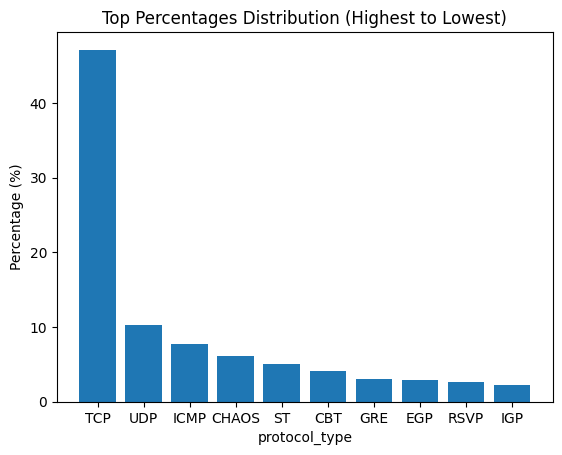

Top 20 Percentages (from Highest to Lowest):
protocol_type
TCP                   47.130530
UDP                   10.242889
ICMP                   7.736383
CHAOS                  6.051682
ST                     5.001598
CBT                    4.070219
GRE                    2.958499
EGP                    2.919691
RSVP                   2.563576
IGP                    2.271378
BBN-RCC-MON            1.435876
XNET                   1.050084
PUP                    1.031822
NVP-II                 1.018125
ARGUS (deprecated)     0.856047
IDRP                   0.849199
HOPOPT                 0.652879
EMCON                  0.641465
IPv4                   0.470255
IPv6-Frag              0.264804
Name: proportion, dtype: float64


In [6]:
# Calculate percentages for each unique value
value_counts = df2['protocol_type'].value_counts(normalize=True) * 100

# Sort percentages from highest to lowest
sorted_percentages = value_counts.sort_values(ascending=False)

# Get top 10 percentages (or fewer if there are less than unique values)
top_percentages = sorted_percentages.head(10)

# Plot histogram for the top values sorted by percentage
plt.bar(top_percentages.index, top_percentages.values)
plt.title("Top Percentages Distribution (Highest to Lowest)")
plt.xlabel("protocol_type")
plt.ylabel("Percentage (%)")
plt.xticks(top_percentages.index)  # Ensure x-axis labels show only top values
plt.show()

# Print the top sorted percentages
print("Top 20 Percentages (from Highest to Lowest):")
print(sorted_percentages[:20])

In [7]:
# Step 1: OneHotEncoding for categorical features
categorical_features = ['protocol_type']
categorical_transformer = OneHotEncoder(sparse_output=False)
encoded_categorical = categorical_transformer.fit_transform(df2[categorical_features])
# print(encoded_categorical)

# Create a DataFrame for the encoded categorical features
encoded_df = pd.DataFrame(encoded_categorical, columns=categorical_transformer.get_feature_names_out(categorical_features))

# Drop the original categorical columns and concatenate the encoded features
df2_filtered = df2.drop(categorical_features, axis=1)
df2_filtered = pd.concat([df2_filtered, encoded_df], axis=1)
df2_filtered.head()

,flow_duration,header_length,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,protocol_type_RSVP,protocol_type_SDRP,protocol_type_ST,protocol_type_TCP,protocol_type_TP++,protocol_type_TRUNK-1,protocol_type_TRUNK-2,protocol_type_UDP,protocol_type_XNET,protocol_type_XTP
0,1.828260,171,64.00,1,1,0.0,False,True,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.094752,60,65.91,2,2,0.0,False,True,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.775582,583305,63.60,101,101,0.0,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.488923,3754787,63.85,2722,2722,0.0,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.264529,132935,47.00,113,113,0.0,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
onehot_cols = ['http','https','dns','telnet','smtp','ssh','irc','tcp','udp','dhcp','arp','icmp','ipv','llc']
onehot_cols.extend(encoded_df.columns.tolist())
# print(f'onehot_cols:{onehot_cols}')
from scipy.stats import chi2_contingency

def cramers_v(contingency_table):
    """Calculate Cramér's V for a contingency table."""
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def filter_strong_association_features(df, target, threshold=0.3):
    """
    Filter binary/categorical features strongly associated with a categorical target label.

    Parameters:
        df (pd.DataFrame): DataFrame containing features and the target label.
        target_col (str): Name of the categorical target label column.
        threshold (float): Minimum Cramér's V value to consider a strong association.

    Returns:
        list: List of feature names with strong association.
    """
    strong_features = []

    # Loop through features in the DataFrame
    for col in df.columns:
        # if col == target_col:  # Skip the target column
        #     continue
        if df[col].nunique() <= 10:  # Check if the column is categorical/binary
            # Create a contingency table
            contingency_table = pd.crosstab(df[col], target)

            # Calculate Cramér's V
            cramer_v_value = cramers_v(contingency_table)

            # If Cramér's V exceeds the threshold, consider it strongly associated
            if cramer_v_value >= threshold:
                strong_features.append(col)

    return strong_features

cols_valueable = filter_strong_association_features(df2_filtered,label34, threshold=0.3)
print(f'cols_valueable in onehotcode:{cols_valueable}')

/tmp/ipykernel_18/3787269871.py:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
/tmp/ipykernel_18/3787269871.py:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
/tmp/ipykernel_18/3787269871.py:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
/tmp/ipykernel_18/3787269871.py:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
/tmp/ipykernel_18/3787269871.py:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
/tmp/ipykernel_18/3787269871.py:10: RuntimeWarning: invalid value encountered in divide
  return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))


cols_valueable in onehotcode:['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'fin_count', 'http', 'https', 'ssh', 'tcp', 'udp', 'icmp', 'protocol_type_CBT', 'protocol_type_CHAOS', 'protocol_type_EGP', 'protocol_type_GRE', 'protocol_type_ICMP', 'protocol_type_IDRP', 'protocol_type_RSVP', 'protocol_type_TCP', 'protocol_type_UDP']


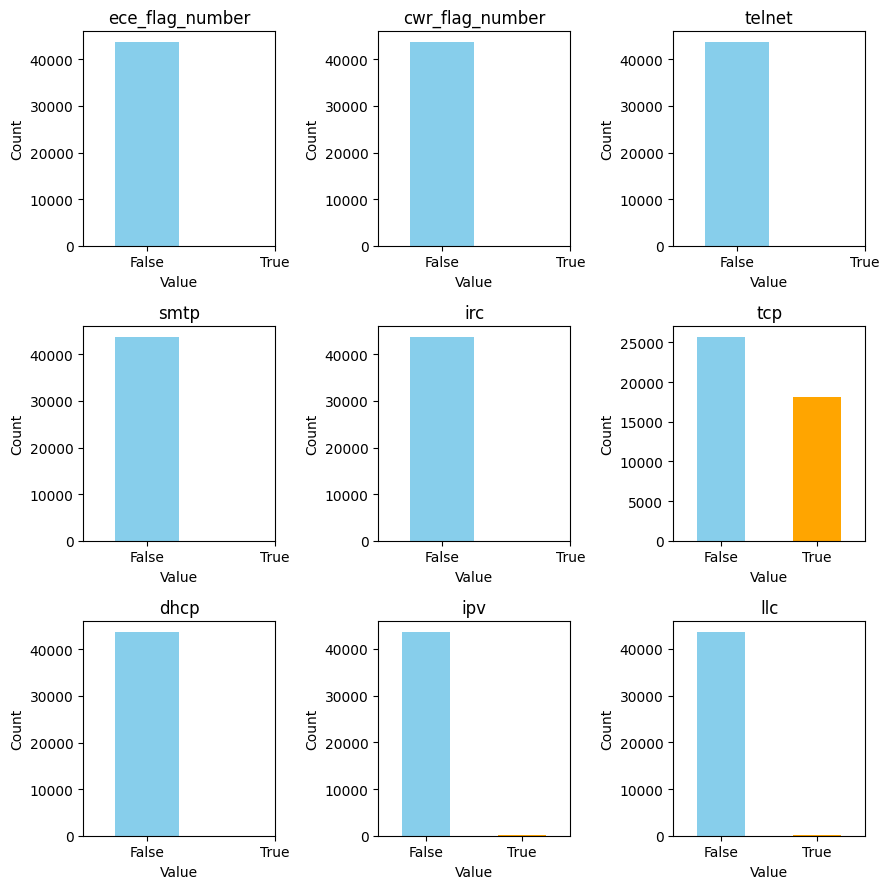

In [9]:
# filter out columns with uniform distribution(always the same value)
skewness = df2_filtered.skew()
# print(skewness)

df2_ls = df2_filtered.loc[:,skewness<0.00001]

# Create a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each column's histogram in the corresponding subplot
for i, column in enumerate(df2_ls.columns):
    # Count the occurrences of True and False
    value_counts = df2_ls[column].value_counts()
    # Plot the histogram
    value_counts.plot(kind='bar', color=['skyblue', 'orange'], ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

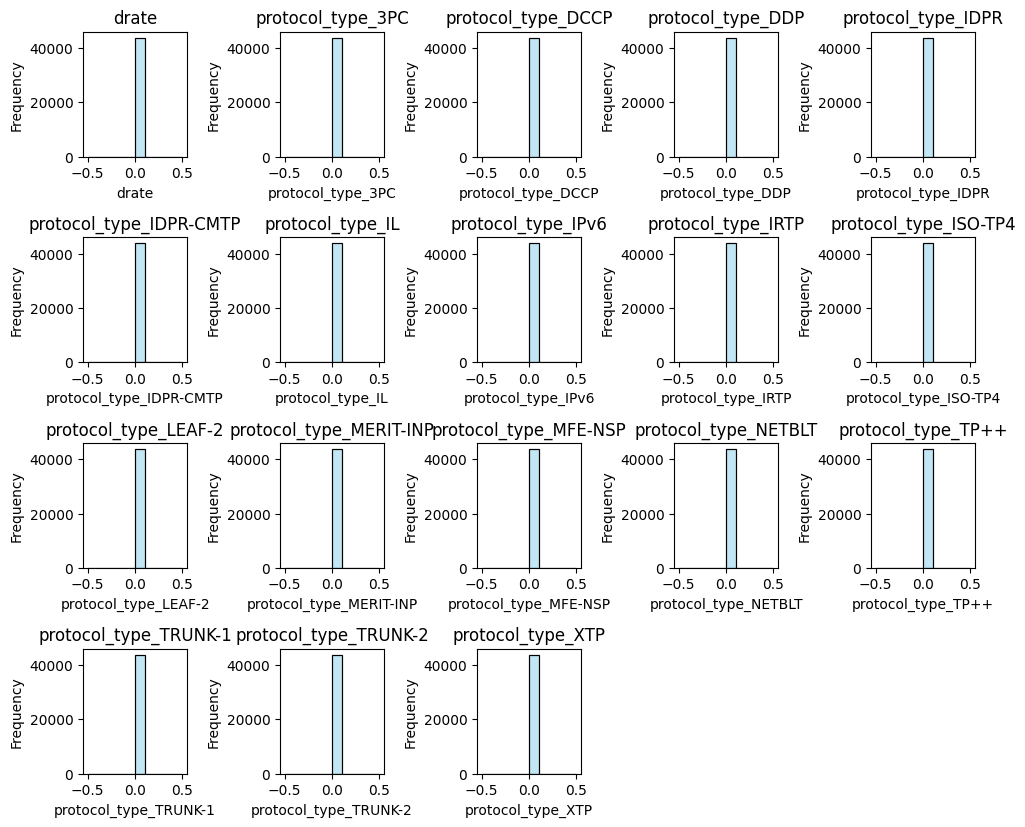

In [10]:
# analyze the colunmn with high abs skew values
df2_hs = df2_filtered.loc[:,abs(skewness)>50]

# print(df2_hs.head(10))

# # Identify continuous columns (e.g., numeric columns)
continuous_columns = df2_hs.select_dtypes(include=['float64', 'int64']).columns

# Set up the plotting
plt.figure(figsize=(10, 10))

# delete columns with too high skewness
from scipy.stats import mstats

df_winsorized = df2_hs[continuous_columns].apply(lambda x: mstats.winsorize(x, limits=[0.05, 0.05]))

# Loop through continuous columns and plot histograms
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(5,5, i)
    sns.histplot(df_winsorized[col], kde=True, bins=10, color='skyblue', edgecolor='black')  # histogram with KDE
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Step 2: drop features of both low variance and low correlation with target label.
var_thr = VarianceThreshold(threshold = VAR_THR) #Removing both constant and quasi-constant
var_thr.fit(df2_filtered)

var_thr.get_support()
concol = [column for column in df2_filtered.columns
          if column not in df2_filtered.columns[var_thr.get_support()]]
print(f'columns of low variance: {concol}')

columns of low variance: ['drate', 'ece_flag_number', 'cwr_flag_number', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'dhcp', 'arp', 'ipv', 'llc', 'protocol_type_3PC', 'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON', 'protocol_type_DCCP', 'protocol_type_DDP', 'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT', 'protocol_type_IDPR', 'protocol_type_IDPR-CMTP', 'protocol_type_IDRP', 'protocol_type_IGMP', 'protocol_type_IGP', 'protocol_type_IL', 'protocol_type_IPv4', 'protocol_type_IPv6', 'protocol_type_IPv6-Frag', 'protocol_type_IPv6-Route', 'protocol_type_IRTP', 'protocol_type_ISO-TP4', 'protocol_type_LEAF-2', 'protocol_type_MERIT-INP', 'protocol_type_MFE-NSP', 'protocol_type_NETBLT', 'protocol_type_NVP-II', 'protocol_type_PUP', 'protocol_type_RSVP', 'protocol_type_SDRP', 'protocol_type_TP++', 'protocol_type_TRUNK-1', 'protocol_type_TRUNK-2', 'protocol_type_XNET', 'protocol_type_XTP']


In [12]:
# remove the feature of both low variance and low
cols_to_drop = [col for col in concol if col not in cols_valueable]
print(f'cols_to_drop: {cols_to_drop}')
df2_normal = df2_filtered.drop(concol,axis =1)
df2_normal.head()

cols_to_drop: ['drate', 'ece_flag_number', 'cwr_flag_number', 'dns', 'telnet', 'smtp', 'irc', 'dhcp', 'arp', 'ipv', 'llc', 'protocol_type_3PC', 'protocol_type_ARGUS (deprecated)', 'protocol_type_BBN-RCC-MON', 'protocol_type_DCCP', 'protocol_type_DDP', 'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT', 'protocol_type_IDPR', 'protocol_type_IDPR-CMTP', 'protocol_type_IGMP', 'protocol_type_IGP', 'protocol_type_IL', 'protocol_type_IPv4', 'protocol_type_IPv6', 'protocol_type_IPv6-Frag', 'protocol_type_IPv6-Route', 'protocol_type_IRTP', 'protocol_type_ISO-TP4', 'protocol_type_LEAF-2', 'protocol_type_MERIT-INP', 'protocol_type_MFE-NSP', 'protocol_type_NETBLT', 'protocol_type_NVP-II', 'protocol_type_PUP', 'protocol_type_SDRP', 'protocol_type_TP++', 'protocol_type_TRUNK-1', 'protocol_type_TRUNK-2', 'protocol_type_XNET', 'protocol_type_XTP']


,flow_duration,header_length,duration,rate,srate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,...,weight,magnitude,protocol_type_CBT,protocol_type_CHAOS,protocol_type_EGP,protocol_type_GRE,protocol_type_ICMP,protocol_type_ST,protocol_type_TCP,protocol_type_UDP
0,1.828260,171,64.00,1,1,False,True,False,False,False,...,141.55,10.392304,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.094752,60,65.91,2,2,False,True,False,False,False,...,141.55,10.495475,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,13.775582,583305,63.60,101,101,False,False,False,False,True,...,38.50,101.073670,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.488923,3754787,63.85,2722,2722,False,False,False,False,False,...,141.55,33.241130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.264529,132935,47.00,113,113,False,False,False,False,True,...,38.50,11.489125,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


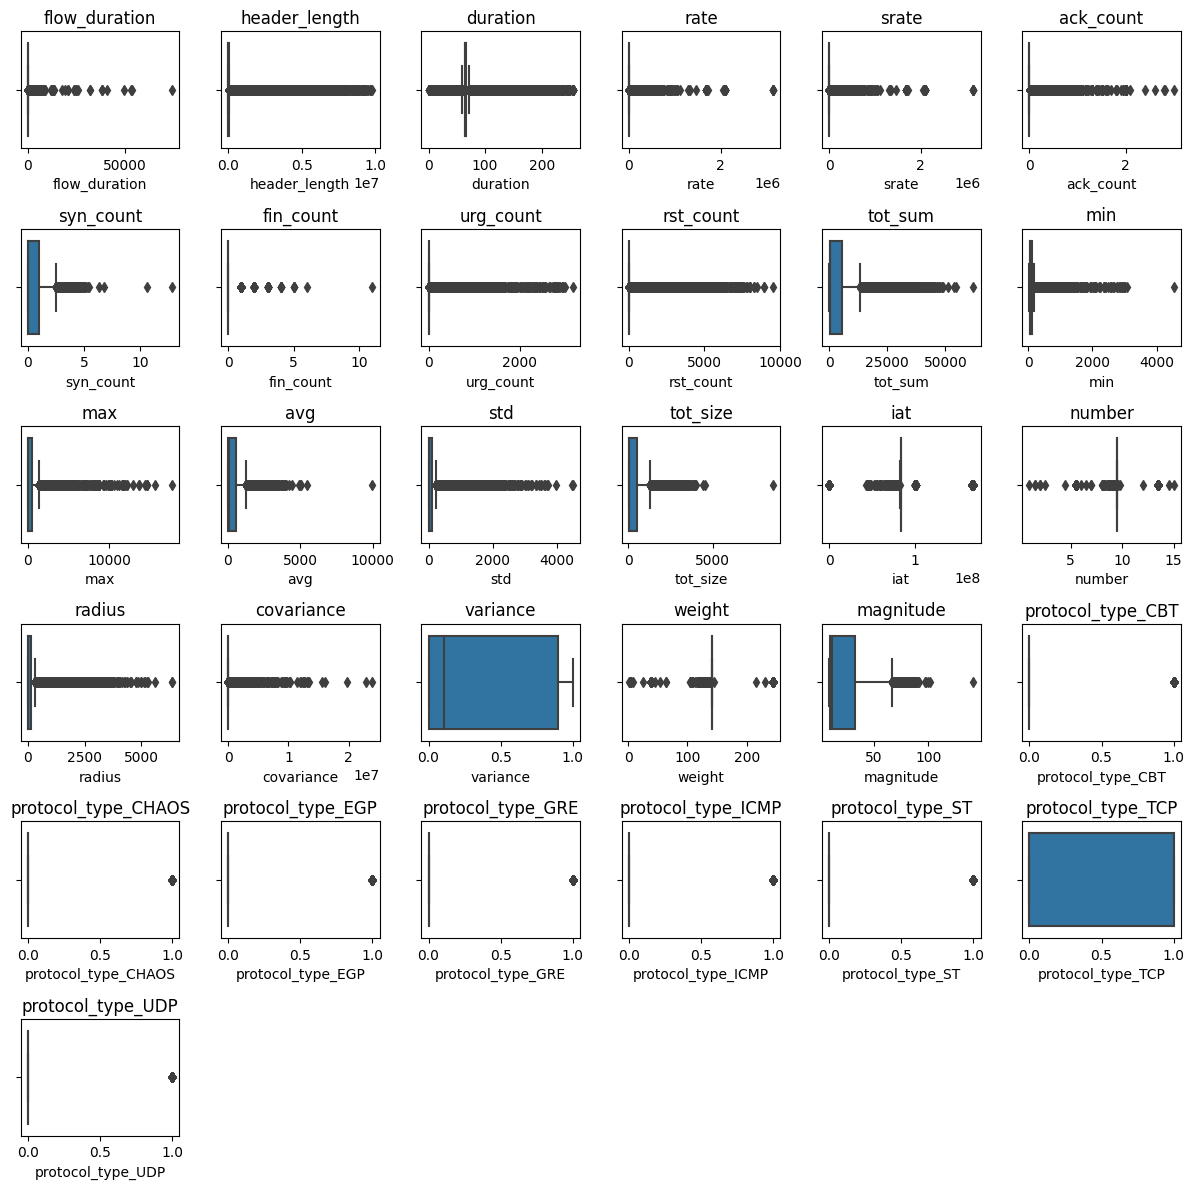

In [13]:
# show boxplot of parameter with comparatively normal distribution
continuous_columns = df2_normal.select_dtypes(include=['float64', 'int64']).columns

# Create a grid for the boxplots
plt.figure(figsize=(12, 12))

# Loop through each column and plot the boxplot
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(6,6, i)
    sns.boxplot(x=df2_normal[col])
    plt.title(f'{col}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

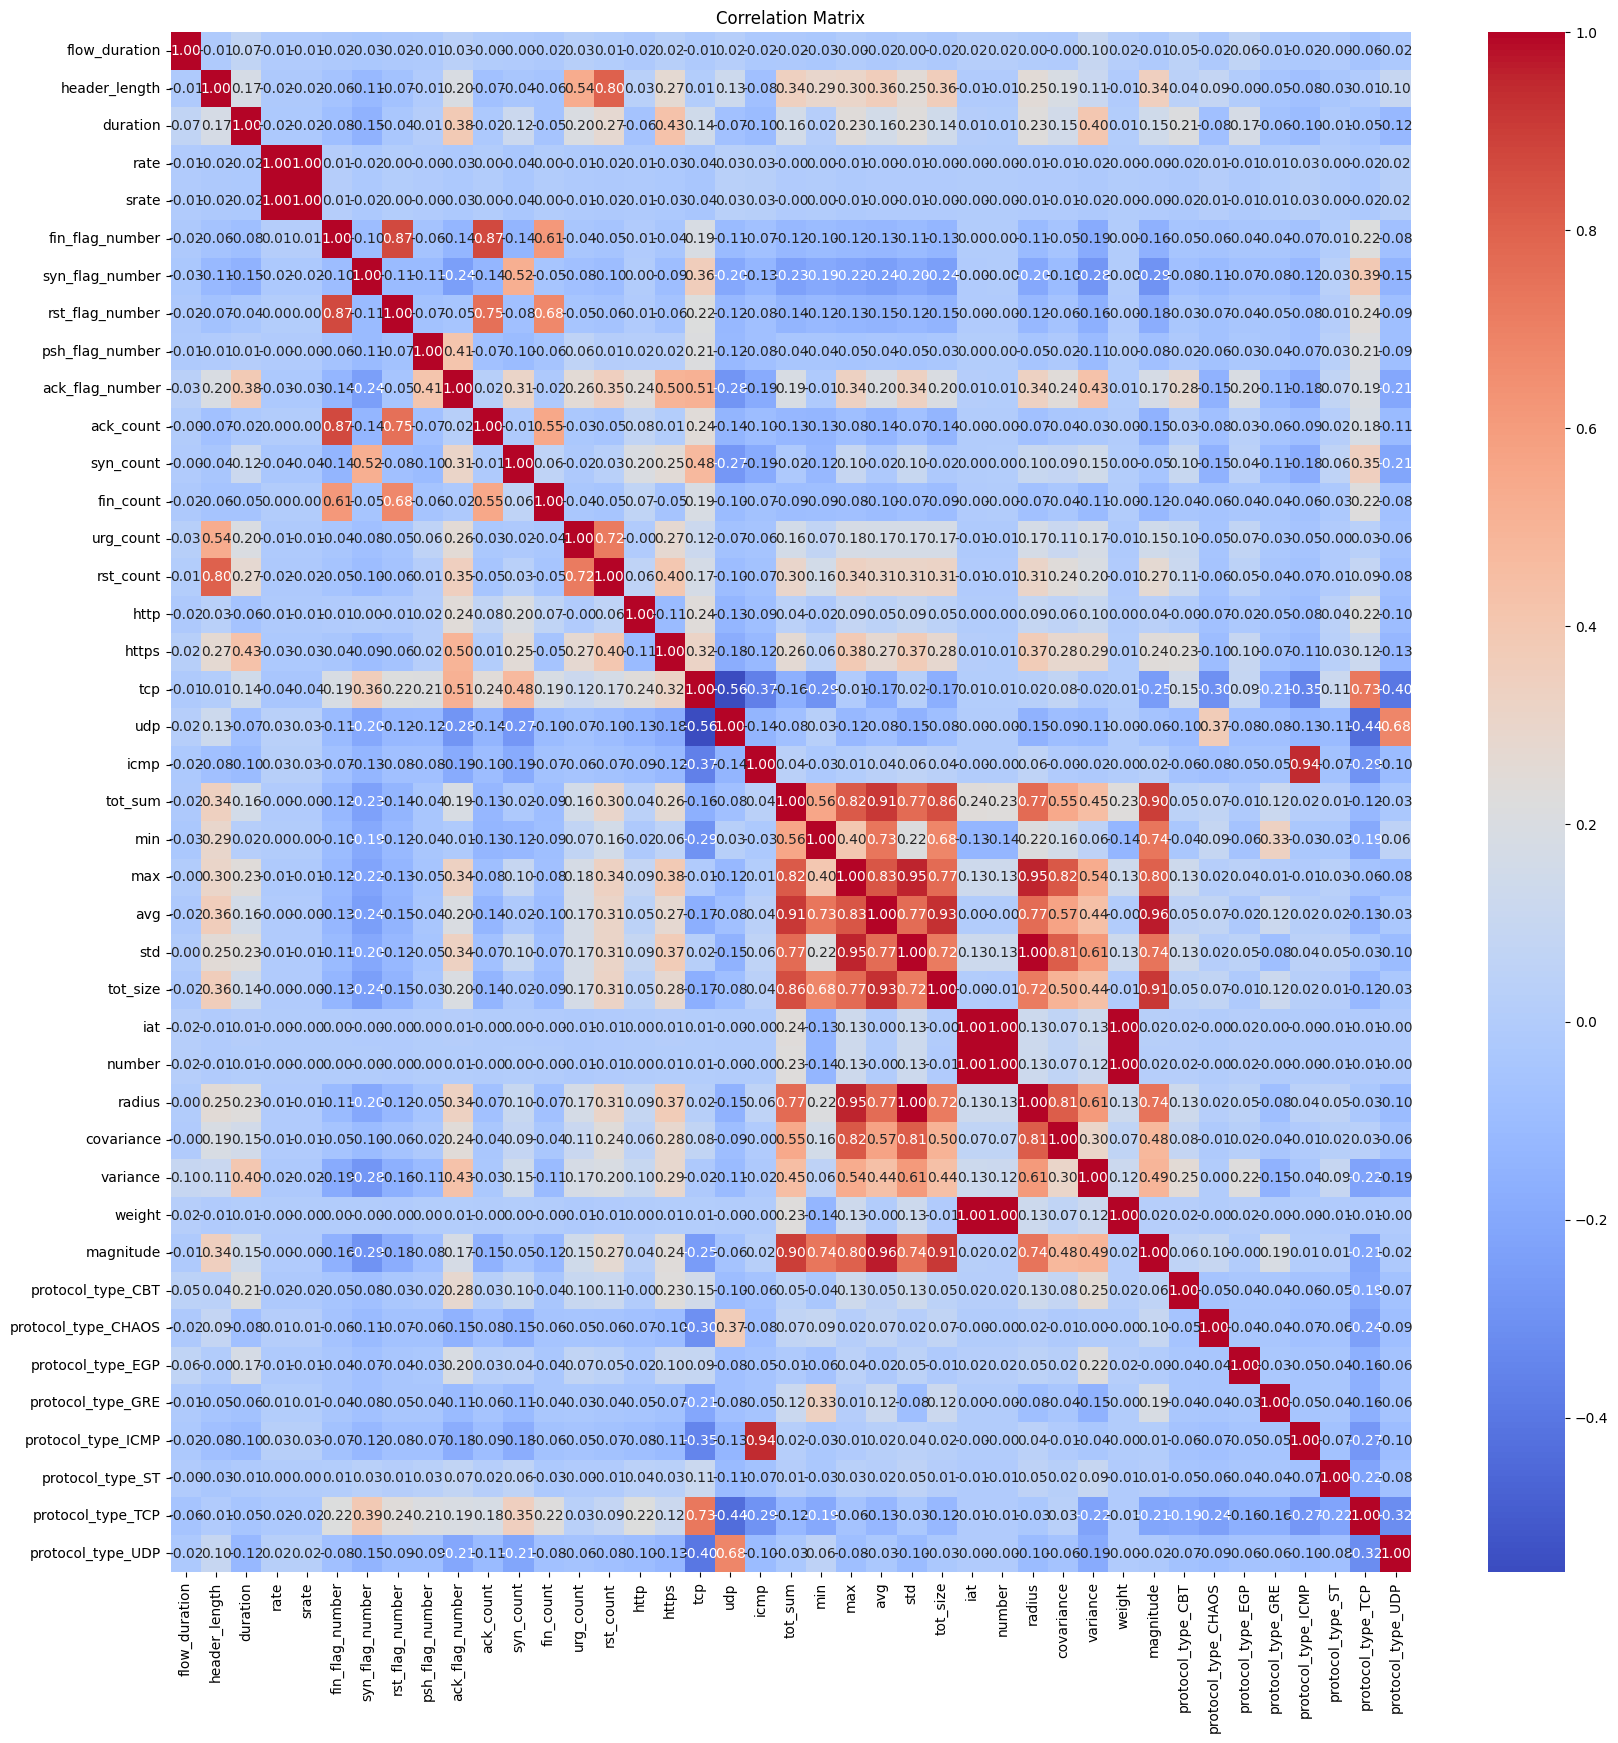

In [14]:
# Correlation Analysis
def show_corr(df):
    corr_matrix = df.corr()

    # Visualize the correlation matrix

    plt.figure(figsize=(20, 20))

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.xticks(rotation=90)
    plt.title('Correlation Matrix')
    plt.show()
show_corr(df2_normal)

In [15]:
# Step 3: Drop highly correlated features
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop_ = None

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)

        # Compute the correlation matrix
        corr_matrix = X.corr().abs()

        # Identify highly correlated features
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper_triangle.columns if any(upper_triangle[column] > self.threshold)]
        print(f'column of high correlation({self.threshold}) to be dropped: {self.to_drop_}')
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)

        # Drop identified columns
        return X.drop(columns=self.to_drop_, errors='ignore')

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
df_reduced = CorrelationFilter(threshold=CORR_THR).fit_transform(df2_normal)
# df_reduced = CorrelationFilter(threshold=0.9).fit_transform(df2_normal)

column of high correlation(0.93) to be dropped: ['srate', 'std', 'number', 'radius', 'weight', 'magnitude', 'protocol_type_ICMP']


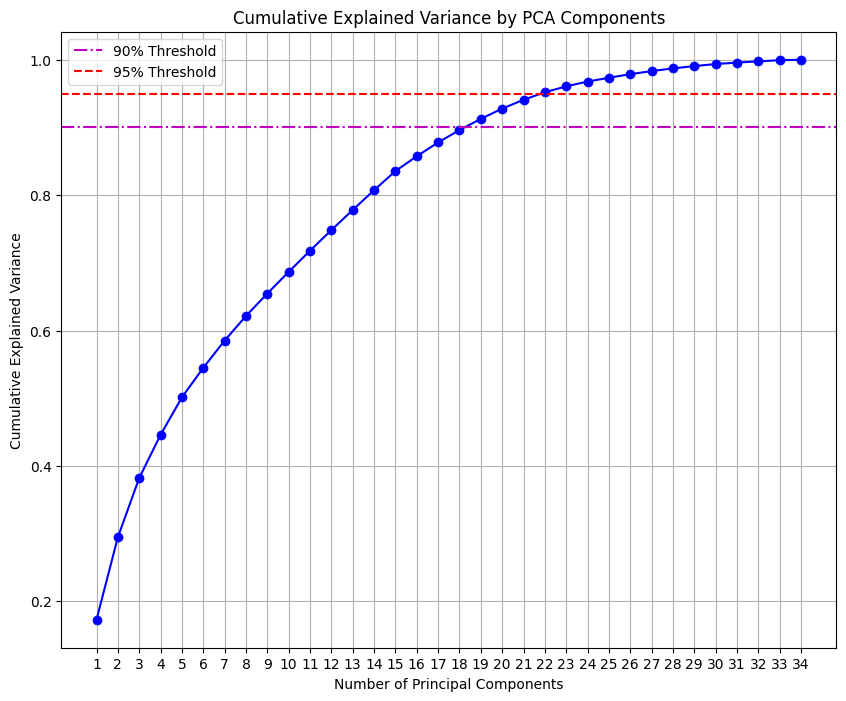

In [16]:
# Step4:reduce dimension Using PCA
from sklearn.decomposition import PCA

def CumuPlot(df):
    # Apply PCA with the adjusted number of components
    pca = PCA()

    df_pca = pca.fit_transform(df)

    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.axhline(y=0.90, color='m', linestyle='-.', label='90% Threshold')  # Optional threshold line
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')  # Optional threshold line
    plt.xticks(range(1, len(cumulative_variance) + 1))  # Ensure x-ticks align with components
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.legend()
    plt.grid()
    plt.show()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_reduced)
CumuPlot(df_scaled)

In [17]:
# Apply PCA and retain the top n components
n_components = 20 #take 95% variance as target
pca = PCA(n_components=n_components)

df_scaled = pd.DataFrame(df_scaled)
principal_components = pca.fit_transform(df_scaled)

# print(scaler.fit_transform(principal_components)[:5])

# Get PCA components (loadings)
components = pca.components_

df = df_reduced
# Compute the importance of each feature
importance = components.T  # Transpose to make features the rows
importance_scores = pd.DataFrame(importance, columns=[f'PC{i+1}' for i in range(components.shape[0])], index=df.columns)

# Calculate the total contribution of each feature across all PCs
top_n = 20  # Change this to the desired number of features
importance_scores['Total'] = (importance_scores.abs() * pca.explained_variance_ratio_).sum(axis=1)
print(f"Top({top_n}) features of  importance: ")
print(importance_scores['Total'].sort_values(ascending=False).head(top_n))

Top(20) features of  importance: 
https                0.136314
min                  0.132785
duration             0.132362
syn_flag_number      0.131520
ack_flag_number      0.131006
covariance           0.130449
protocol_type_TCP    0.126199
protocol_type_CBT    0.125941
rst_count            0.122431
urg_count            0.122315
protocol_type_GRE    0.121709
protocol_type_UDP    0.121604
syn_count            0.120329
variance             0.119322
http                 0.116514
protocol_type_EGP    0.116164
icmp                 0.115650
max                  0.114996
avg                  0.112023
tot_sum              0.111801
Name: Total, dtype: float64


In [18]:
# build up pipeline for structured preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# determine categorical and numerical features
numerical_feature = df2.select_dtypes(include=['int64', 'float64']).columns
# categorical_ix = df2.select_dtypes(include=['object', 'bool']).columns

# Preprocessing for numeric and categorical features
label_cols = ["benign","label"]
skip_cols = categorical_features + label_cols
pass_cols = [col for col in df2.columns if col not in skip_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ],remainder='passthrough')

# Create the pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance_filter", VarianceThreshold(threshold = VAR_THR)),
    ("correlation_filter", CorrelationFilter(threshold=CORR_THR)),
    ("scaler", StandardScaler()),
    ("pca", pca)
])

## Models Selection & Evaluation
|Model|Type|Advantage|
|--|--|--|
|Logistic Regression|Supervised  |Easy to implement, computational efficient|
|KNN               |Supervised  |widely-used for classification of known number(k) of clusters, can upgrade to outlier robust variant: DBSCAN|
|k-means           |Unsupervised  |used to used as comparison with KNN, not applied in this experiment|
|Random Forest     |Supervised|Ensemble decision trees, robust to skewness of data|
|Auto-encoder      |Unsupervised|Deep Learning model for abnormal detection, which only differentiate benign and attack flow|

Supervised models will be trained and evaluated on 0.1 percent data in classifying 2/8/34 traffic category, including Benign and Attacking case.

In [19]:
def split(df,label = "label"):

    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]

    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RANDOM_STATE)

    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)

    # return X_train, X_test, y_train, y_test
    return scaled_X_train, scaled_X_test, y_train, y_test

In [20]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "KNN", "Random Forest"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

In [21]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [22]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, X_test, y_test, target_names, classes, model_name):
    pred = model.predict(X_test)

    # print(pred[:5])
    # print(f'y_test.type:{type(y_test)}.shape:{y_test.shape} & y_test.type:{type(pred)}.shape:{pred.shape}')
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])

    print(classification_report(y_test, pred, digits = 3))

    if classes == 2 or classes == 8:
        plt.figure(figsize = (4, 2), dpi = 300)
        ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                               display_labels = target_names).plot()
        plt.title(model_name)
        plt.xticks(rotation=30)

In [23]:
# save and load models for testing on different percentage of data
!mkdir models
def pickle_save(model, name):
    model_filename = 'models/' + name + '.pkl'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)

    print(f"Model saved to {name}")

def pickle_load(name):
    model_filename = 'models/' + name + '.pkl'
    try:
        with open(model_filename, 'rb') as model_file:
            model = pickle.load(model_file)
        print(f"Model loaded from {model_filename}")
        return model
    except FileNotFoundError:
        print(f"Error: The file '{model_filename}' does not exist.")
        return None
    except pickle.UnpicklingError:
        print(f"Error: Failed to load the model from '{model_filename}'. The file might be corrupted.")
        return None

In [24]:
# print(df2_xs)
df_processed = pd.DataFrame(pipeline.fit_transform(df2))
# df_processed = pd.DataFrame(pca.fit_transform(df_reduced))
# df_processed = pd.read_csv("/kaggle/input/pca-transformed/pca_transformed_data_v11.csv")
# print(df_pca.head())
print(df_processed.shape)
df_processed["label"] = label2
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
target_names = ["Attack", "Benign"]
# print(label2.head())

column of high correlation(0.93) to be dropped: [12, 27, 32, 35, 36, 39, 40]
(43806, 20)


              precision    recall  f1-score   support

       False      0.969     0.993     0.981      8435
        True      0.487     0.171     0.253       327

    accuracy                          0.962      8762
   macro avg      0.728     0.582     0.617      8762
weighted avg      0.951     0.962     0.954      8762

Model saved to logreg_2


<Figure size 1200x600 with 0 Axes>

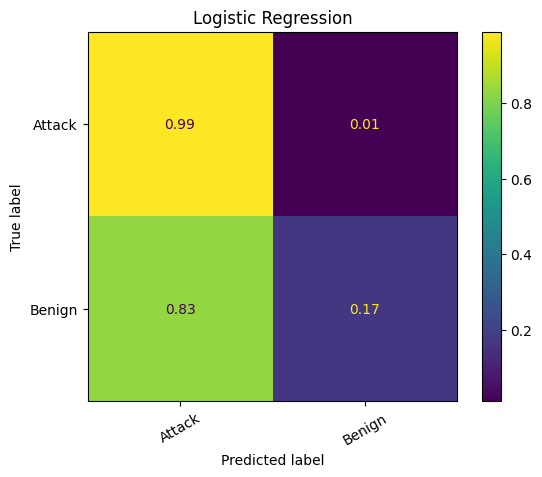

In [25]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 2, "Logistic Regression")
pickle_save(logreg_model, "logreg_2")

              precision    recall  f1-score   support

       False      0.972     0.995     0.983      8435
        True      0.651     0.251     0.362       327

    accuracy                          0.967      8762
   macro avg      0.811     0.623     0.673      8762
weighted avg      0.960     0.967     0.960      8762

Model saved to knn_2


<Figure size 1200x600 with 0 Axes>

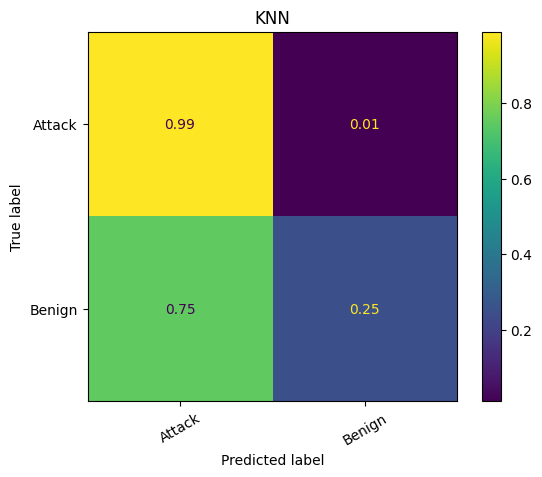

In [26]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 2, "KNN")
pickle_save(knn, "knn_2")

              precision    recall  f1-score   support

       False      0.974     0.994     0.984      8435
        True      0.667     0.324     0.436       327

    accuracy                          0.969      8762
   macro avg      0.820     0.659     0.710      8762
weighted avg      0.963     0.969     0.963      8762

Model saved to rfc_2


<Figure size 1200x600 with 0 Axes>

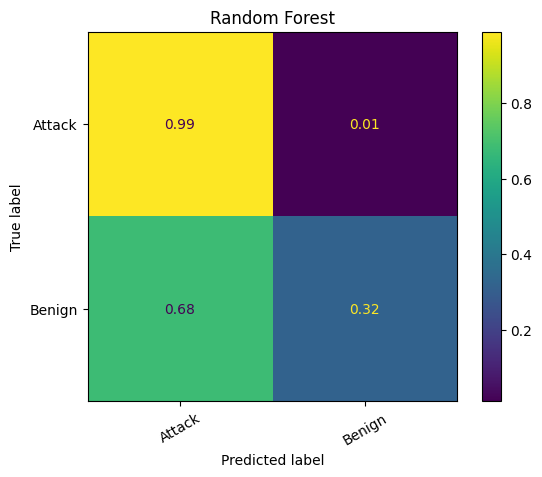

In [27]:
# Weight-balanced
# rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 2, "Random Forest")
pickle_save(rfc, "rfc_2")

In [28]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv(f'{output_path}/metrics_2.csv', index=True)
metrics_2

,Logistic Regression,KNN,Random Forest
Accuracy,0.962337,0.967017,0.968729
Recall,0.58213,0.622774,0.658938
Precision,0.727808,0.811212,0.820489
F1-Score,0.617038,0.672551,0.710066


### 8 Classes

In [29]:
df_processed = pd.DataFrame(pipeline.fit_transform(df8))
df_processed['label']=label8
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)

column of high correlation(0.93) to be dropped: [12, 27, 32, 35, 36, 39, 40]


              precision    recall  f1-score   support

      Benign      0.536     0.388     0.450       327
  BruteForce      0.125     0.008     0.015       122
        DDoS      0.726     0.939     0.819      4150
         DoS      0.512     0.142     0.222      1361
       Mirai      0.981     0.983     0.982       938
       Recon      0.484     0.541     0.511       835
    Spoofing      0.546     0.454     0.496       471
         Web      0.460     0.418     0.438       558

    accuracy                          0.689      8762
   macro avg      0.546     0.484     0.492      8762
weighted avg      0.655     0.689     0.648      8762

Model saved to logreg_8


<Figure size 1200x600 with 0 Axes>

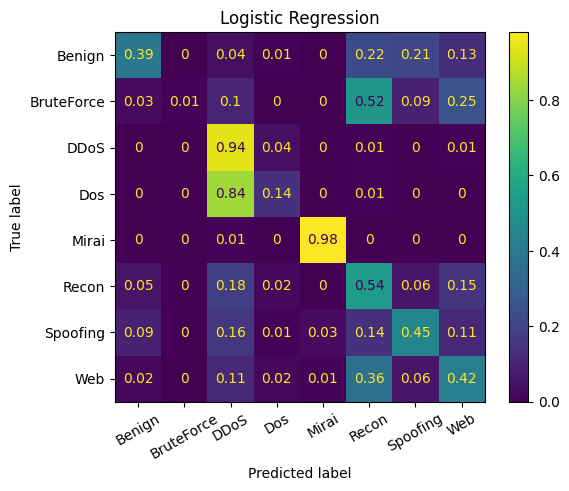

In [30]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 8, "Logistic Regression")
pickle_save(logreg_model, "logreg_8")

              precision    recall  f1-score   support

      Benign      0.507     0.541     0.524       327
  BruteForce      0.310     0.180     0.228       122
        DDoS      0.874     0.809     0.840      4150
         DoS      0.536     0.655     0.589      1361
       Mirai      0.993     0.988     0.990       938
       Recon      0.632     0.672     0.652       835
    Spoofing      0.646     0.541     0.589       471
         Web      0.522     0.581     0.550       558

    accuracy                          0.744      8762
   macro avg      0.627     0.621     0.620      8762
weighted avg      0.755     0.744     0.747      8762

Model saved to knn_8


<Figure size 1200x600 with 0 Axes>

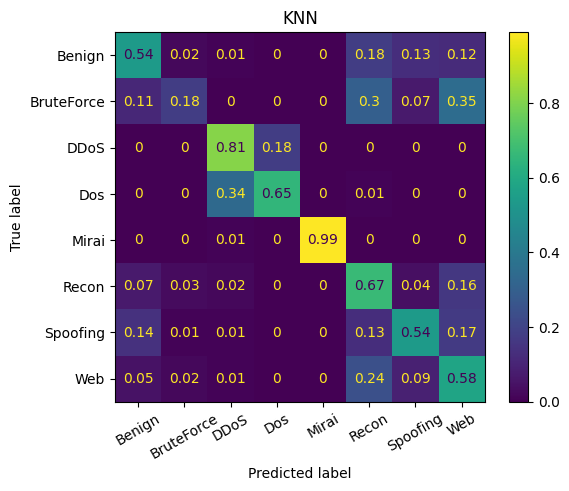

In [31]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 8, "KNN")
pickle_save(knn, "knn_8")

              precision    recall  f1-score   support

      Benign      0.575     0.483     0.525       327
  BruteForce      0.513     0.164     0.248       122
        DDoS      0.846     0.864     0.855      4150
         DoS      0.568     0.522     0.544      1361
       Mirai      1.000     0.990     0.995       938
       Recon      0.615     0.695     0.652       835
    Spoofing      0.648     0.618     0.633       471
         Web      0.544     0.622     0.580       558

    accuracy                          0.756      8762
   macro avg      0.664     0.620     0.629      8762
weighted avg      0.753     0.756     0.752      8762

Model saved to rfc_8


<Figure size 1200x600 with 0 Axes>

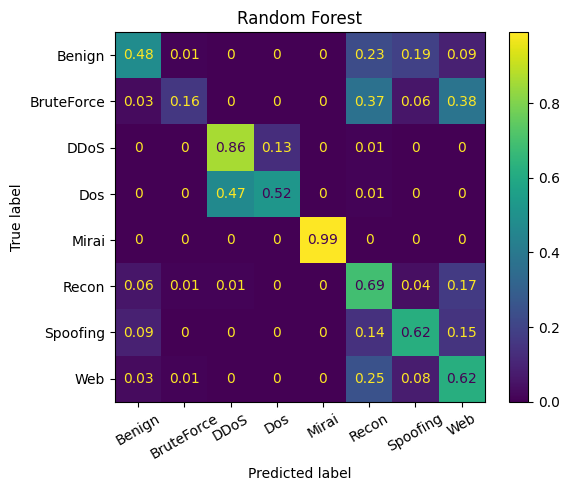

In [32]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 8, "Random Forest")
pickle_save(rfc, "rfc_8")

In [33]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv(f'{output_path}/metrics_8.csv', index=True)
metrics_8

,Logistic Regression,KNN,Random Forest
Accuracy,0.689226,0.743552,0.755764
Recall,0.484199,0.620951,0.61973
Precision,0.546196,0.6274,0.663576
F1-Score,0.491677,0.620231,0.629107


### 34 Classes

In [34]:
df_processed = pd.DataFrame(pipeline.fit_transform(df34))
df_processed['label']=label34
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
print(y_test.value_counts())
target_names = list(y_test.unique())

column of high correlation(0.93) to be dropped: [12, 27, 32, 35, 36, 39, 40]
label
DDoS-ICMP_Flood            484
DDoS-UDP_Flood             456
DDoS-TCP_Flood             438
DDoS-RSTFINFlood           432
DDoS-SYN_Flood             432
DDoS-PSHACK_Flood          432
DDoS-SynonymousIP_Flood    418
DoS-UDP_Flood              412
DoS-TCP_Flood              395
DoS-SYN_Flood              371
BenignTraffic              328
Mirai-greeth_flood         322
Mirai-udpplain             313
Mirai-greip_flood          303
DDoS-ICMP_Fragmentation    272
MITM-ArpSpoofing           248
DDoS-ACK_Fragmentation     246
DDoS-UDP_Fragmentation     246
DNS_Spoofing               223
Recon-HostDiscovery        207
Recon-OSScan               198
Recon-PortScan             189
DoS-HTTP_Flood             182
VulnerabilityScan          160
DDoS-HTTP_Flood            151
DDoS-SlowLoris             143
DictionaryBruteForce       122
BrowserHijacking           104
CommandInjection           101
SqlInjection      

In [35]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 34, "Logistic Regression")
pickle_save(logreg_model, "logreg_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.526     0.116     0.190        86
          BenignTraffic      0.270     0.625     0.377       328
       BrowserHijacking      0.179     0.048     0.076       104
       CommandInjection      0.875     0.139     0.239       101
 DDoS-ACK_Fragmentation      0.898     0.972     0.934       246
        DDoS-HTTP_Flood      0.654     0.702     0.677       151
        DDoS-ICMP_Flood      0.992     1.000     0.996       484
DDoS-ICMP_Fragmentation      0.901     0.967     0.933       272
      DDoS-PSHACK_Flood      0.986     0.993     0.990       432
       DDoS-RSTFINFlood      0.995     1.000     0.998       432
         DDoS-SYN_Flood      0.537     0.931     0.681       432
         DDoS-SlowLoris      0.315     0.392     0.349       143
DDoS-SynonymousIP_Flood      0.655     0.572     0.610       418
         DDoS-TCP_Flood      0.568     0.114     0.190       438
         DDoS-UDP_Flood 

In [36]:
knn = KNeighborsClassifier(n_neighbors = 34)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 34, "KNN")
pickle_save(knn, "knn_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.296     0.186     0.229        86
          BenignTraffic      0.349     0.680     0.461       328
       BrowserHijacking      0.145     0.106     0.122       104
       CommandInjection      0.508     0.297     0.375       101
 DDoS-ACK_Fragmentation      0.967     0.955     0.961       246
        DDoS-HTTP_Flood      0.675     0.702     0.688       151
        DDoS-ICMP_Flood      0.980     0.992     0.986       484
DDoS-ICMP_Fragmentation      0.932     0.963     0.948       272
      DDoS-PSHACK_Flood      0.960     0.988     0.974       432
       DDoS-RSTFINFlood      0.995     0.995     0.995       432
         DDoS-SYN_Flood      0.468     0.322     0.381       432
         DDoS-SlowLoris      0.728     0.692     0.710       143
DDoS-SynonymousIP_Flood      0.756     0.636     0.691       418
         DDoS-TCP_Flood      0.495     0.208     0.293       438
         DDoS-UDP_Flood 

In [37]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 34, "Random Forest")
pickle_save(rfc, "rfc_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.302     0.337     0.319        86
          BenignTraffic      0.422     0.649     0.511       328
       BrowserHijacking      0.210     0.125     0.157       104
       CommandInjection      0.320     0.327     0.324       101
 DDoS-ACK_Fragmentation      0.968     0.988     0.978       246
        DDoS-HTTP_Flood      0.819     0.781     0.800       151
        DDoS-ICMP_Flood      1.000     1.000     1.000       484
DDoS-ICMP_Fragmentation      0.978     0.967     0.972       272
      DDoS-PSHACK_Flood      1.000     0.995     0.998       432
       DDoS-RSTFINFlood      1.000     1.000     1.000       432
         DDoS-SYN_Flood      0.576     0.817     0.676       432
         DDoS-SlowLoris      0.799     0.832     0.815       143
DDoS-SynonymousIP_Flood      0.654     0.605     0.629       418
         DDoS-TCP_Flood      0.511     0.055     0.099       438
         DDoS-UDP_Flood 

In [38]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv(f'{output_path}/metrics_34.csv', index=True)
metrics_34

,Logistic Regression,KNN,Random Forest
Accuracy,0.601233,0.651221,0.686829
Recall,0.486528,0.559142,0.60067
Precision,0.518343,0.577734,0.602709
F1-Score,0.472655,0.554977,0.590408


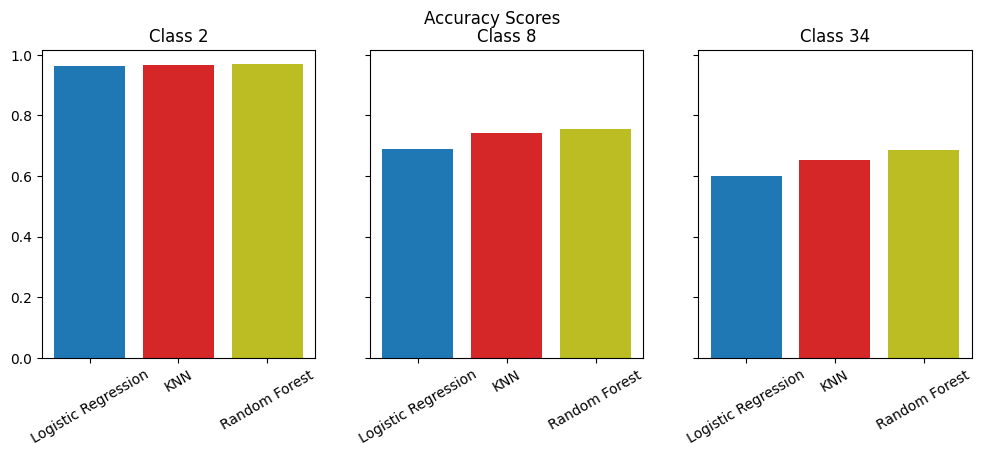

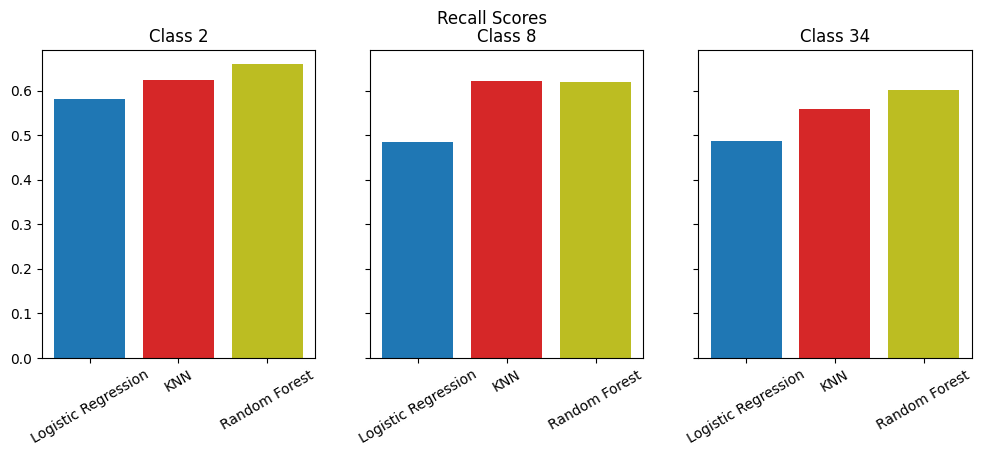

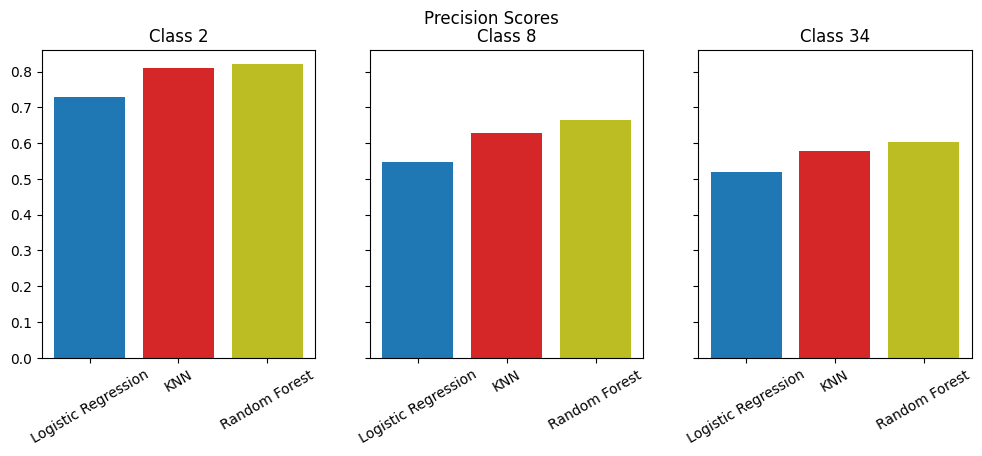

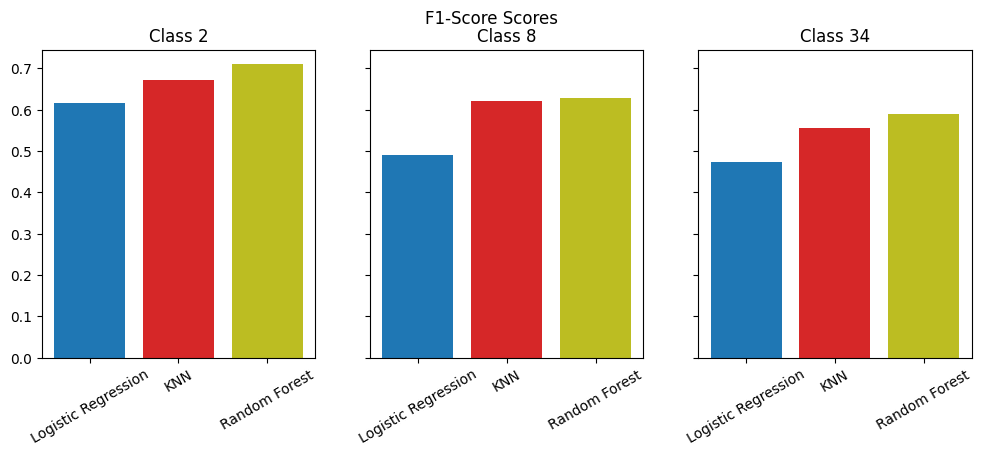

In [39]:
# List of model names
model_names = ["Logistic Regression", "KNN", "Random Forest"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "KNN": 'tab:red',
    "Random Forest": 'tab:olive',
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(12, 4), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")

        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)

        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=30)

    # Save the figure
    plt.savefig(f'{output_path}/{metric}_scores.png', bbox_inches='tight')

    plt.show()

# Efficient Intrution Detection
In real-world application, it requires that the detection will be effective as well as efficient.
One scenario will be analyzed: how models trained in smaller percentage of data perform on larger percentage of data. Though some degree of performance downgrade is observed, the models can stil function and some interesitng findings here:


*   Random Forest perform better for high-density data and worse on low-density ones. The reason behind is likely its tendency of overfitting despite of ensembling the average output of decision tree.
*   KNN perform just the opposite due to its nature to aggregate the local neighbours.




## Evaluation of Models Trained on Smaller Data Subsets Applied to Larger Datasets

column of high correlation(0.93) to be dropped: [12, 27, 32, 35, 36, 39, 40]
Model loaded from models/rfc_8.pkl
              precision    recall  f1-score   support

      Benign      0.521     0.202     0.292      1704
  BruteForce      0.000     0.000     0.000       691
        DDoS      0.744     0.881     0.807     21541
         DoS      0.486     0.171     0.253      7079
       Mirai      0.967     0.990     0.978      4881
       Recon      0.362     0.685     0.474      4455
    Spoofing      0.487     0.535     0.510      2498
         Web      0.474     0.159     0.238      3030

    accuracy                          0.659     45879
   macro avg      0.505     0.453     0.444     45879
weighted avg      0.639     0.659     0.622     45879

Model loaded from models/knn_8.pkl
              precision    recall  f1-score   support

      Benign      0.292     0.159     0.206      1704
  BruteForce      0.044     0.017     0.025       691
        DDoS      0.707     0.542     0

<Figure size 1200x600 with 0 Axes>

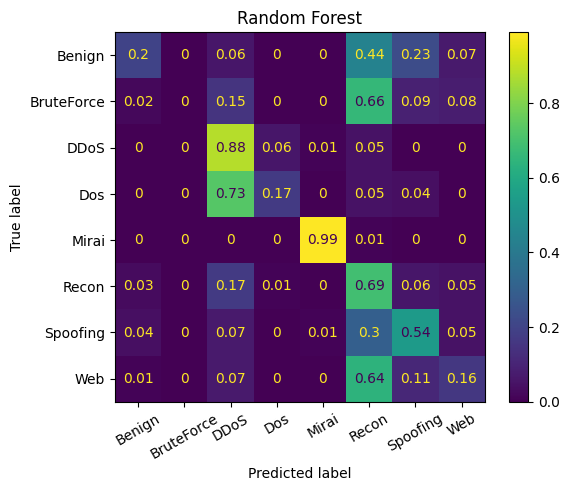

<Figure size 1200x600 with 0 Axes>

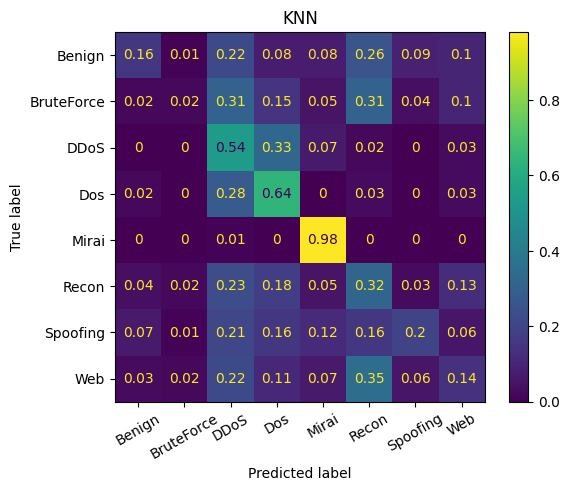

In [40]:
# test model on larger percentage
label8_s = df8_s["label"]
df8 = df8_s.drop(["label"],axis=1)

# Convert NumPy array to DataFrame
df_processed = pd.DataFrame(pipeline.fit_transform(df8))
df_processed['label'] = label8_s
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

rfc8_load = pickle_load("rfc_8")
evaluate(rfc8_load, scaled_X_test , y_test, target_names, 8, "Random Forest")

knn8_load = pickle_load("knn_8")
evaluate(knn8_load, scaled_X_test , y_test, target_names, 8, "KNN")

column of high correlation(0.93) to be dropped: [12, 27, 32, 35, 36, 39, 40]
Model loaded from models/rfc_8.pkl
              precision    recall  f1-score   support

      Benign      0.579     0.237     0.337      3425
  BruteForce      0.463     0.014     0.026      1401
        DDoS      0.758     0.842     0.798     43287
         DoS      0.371     0.201     0.261     14227
       Mirai      0.998     0.991     0.994      9813
       Recon      0.400     0.759     0.524      8568
    Spoofing      0.575     0.541     0.558      5029
         Web      0.402     0.222     0.286      4866

    accuracy                          0.664     90616
   macro avg      0.568     0.476     0.473     90616
weighted avg      0.649     0.664     0.639     90616

Model loaded from models/knn_8.pkl
              precision    recall  f1-score   support

      Benign      0.396     0.249     0.306      3425
  BruteForce      0.079     0.021     0.034      1401
        DDoS      0.697     0.731     0

<Figure size 1200x600 with 0 Axes>

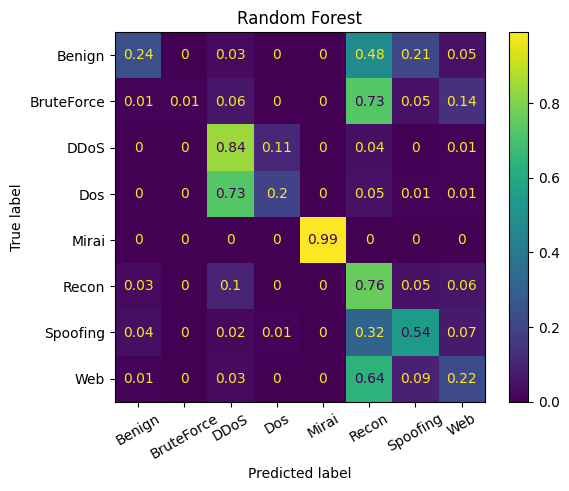

<Figure size 1200x600 with 0 Axes>

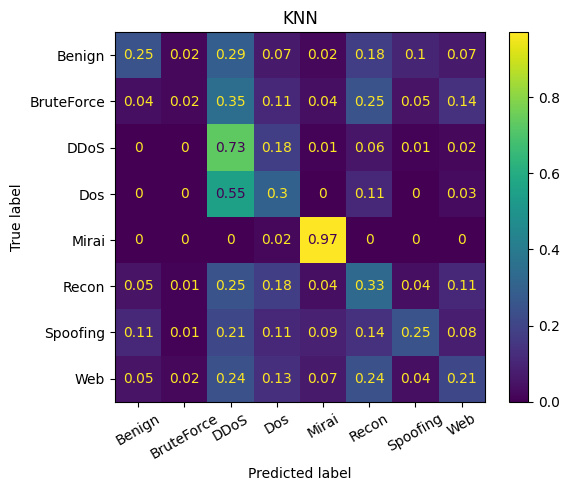

In [41]:
# extract the label value
label8_m = df8_m["label"]
df8 = df8_m.drop(["label"],axis=1)

# Convert NumPy array to DataFrame
df_processed = pd.DataFrame(pipeline.fit_transform(df8))
df_processed['label'] = label8_m
scaled_X_train, scaled_X_test, y_train, y_test = split(df_processed)
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

rfc8_load = pickle_load("rfc_8")
evaluate(rfc8_load, scaled_X_test , y_test, target_names, 8, "Random Forest")

knn8_load = pickle_load("knn_8")
evaluate(knn8_load, scaled_X_test , y_test, target_names, 8, "KNN")

## Autoencoder
Autoencoder has also been used to compare the effect of differentiating benign/malicious traffic with classical models.
Inspired by https://www.kaggle.com/code/alexandrelemercier/quantized-autoencoder-qae-ids-for-iot-devices

normal.shape:(1637, 46)
column of high correlation(0.93) to be dropped: [11, 15, 18, 24, 27, 28, 31, 32]


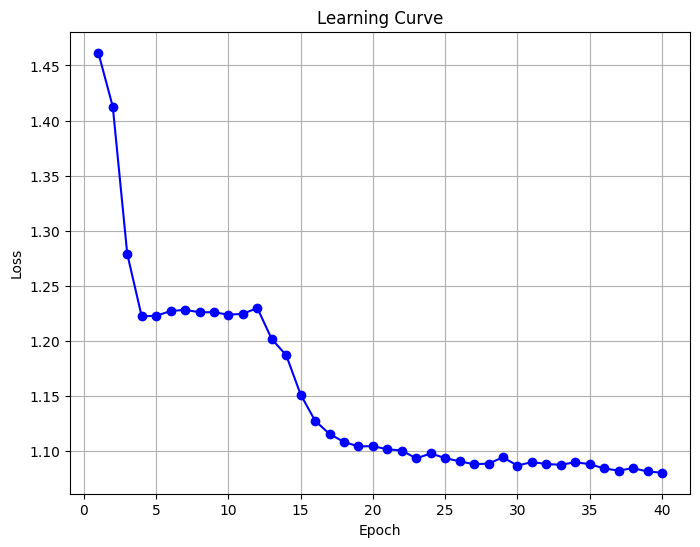

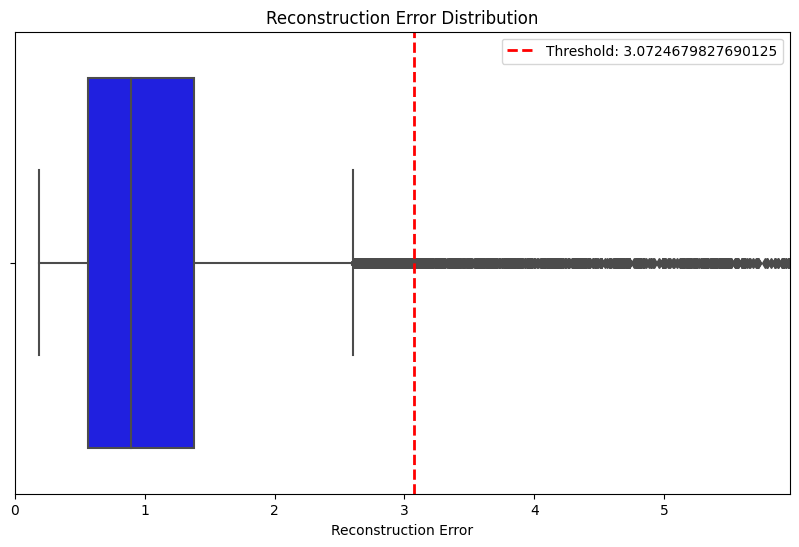

column of high correlation(0.93) to be dropped: [12, 27, 32, 35, 36, 39, 40]
              precision    recall  f1-score   support

         0.0      0.962     0.913     0.937     42169
         1.0      0.030     0.070     0.042      1637

    accuracy                          0.881     43806
   macro avg      0.496     0.492     0.490     43806
weighted avg      0.927     0.881     0.903     43806



<Figure size 1200x600 with 0 Axes>

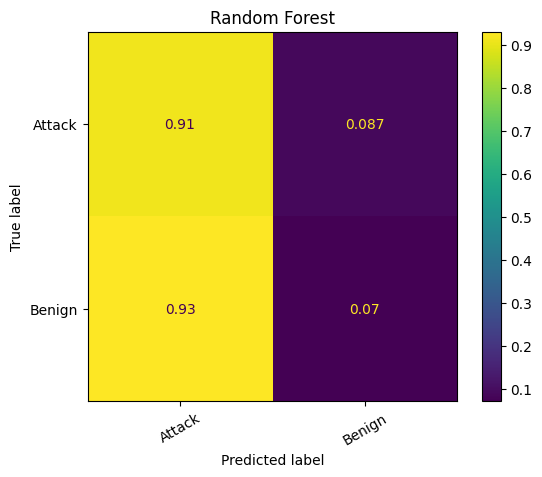

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
class AutoencoderAnomalyDetector(nn.Module):
    def __init__(self, input_dim, threshold=0.1):
        super(AutoencoderAnomalyDetector, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
        self.threshold = threshold

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def predict(self, x):
        with torch.no_grad():
            reconstructed = self.forward(x)
            reconstruction_error = torch.mean((x - reconstructed) ** 2, dim=1)
            return (reconstruction_error > self.threshold).int()

    @staticmethod
    def get_device():
        return "cpu"
        # return torch.device('mps' if torch.backends.mps.is_available() else
        #                     'cuda' if torch.cuda.is_available() else 'cpu')

    def train_model(self, dataloader, epochs=20, lr=1e-3):
        device = self.get_device()
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        self.train()

        epoch_losses = []
        reconstruction_error = []
        for epoch in range(epochs):
            total_loss = 0
            for batch in dataloader:
                data = batch[0].to(device)
                optimizer.zero_grad()
                reconstructed = self.forward(data)
                loss = criterion(reconstructed, data)
                loss.backward()
                optimizer.step()
                reconstruction_error.extend(torch.mean((data - reconstructed) ** 2, dim=1).cpu().detach().numpy())
                total_loss += loss.item()
            avg_loss = total_loss / len(dataloader)
            epoch_losses.append(avg_loss)
            # print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
        
        self.threshold = np.mean(reconstruction_error) + 1.5 * np.std(reconstruction_error)
        self.plot_learning_curve(epoch_losses)
        self.plot_reconstruction_error_boxplot(reconstruction_error, self.threshold, "Reconstruction Error Distribution")
        return epoch_losses

    def evaluate(self, dataloader, y_true):
        device = self.get_device()
        self.to(device)
        self.eval()
        y_pred = []
        with torch.no_grad():
            for batch in dataloader:
                data = batch[0].to(device)
                preds = self.predict(data)
                y_pred.extend(preds.cpu().numpy())
        # print(f'y_pred:{len(y_pred)} & y_true:{len(y_true)}')
        print(classification_report(y_true, y_pred, digits = 3))
        plt.figure(figsize = (4, 2), dpi = 300)
        target_names = ["Attack", "Benign"]
        ConfusionMatrixDisplay(np.round(confusion_matrix(y_true, y_pred, normalize="true"), 4),
                               display_labels = target_names).plot()
        plt.title(model_name)
        plt.xticks(rotation=30)

    @staticmethod
    def plot_learning_curve(losses):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='b')
        plt.title("Learning Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()
    
    # Plotting function remains unchanged
    @staticmethod
    def plot_reconstruction_error_boxplot(reconstruction_error, threshold, title):
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=reconstruction_error, color='blue')
        plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold}')
        plt.title(title)
        plt.xlabel('Reconstruction Error')
        plt.legend()
        plt.xlim([0, np.percentile(reconstruction_error, 99)])
        plt.show()

from torch.utils.data import DataLoader, TensorDataset

normal = df2[label2] # Normal data
print(f'normal.shape:{normal.shape}')

# Combine the normal and anomaly data
df_tr = pipeline.fit_transform(normal) # Normal data

# print(f'df_tr.shape:{df_tr.shape}')
# Convert to PyTorch tensors
X = torch.tensor(df_tr, dtype=torch.float32)
# y = torch.tensor(y_train.values, dtype=torch.float32)

# DataLoader
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Train the model
detector = AutoencoderAnomalyDetector(input_dim=X.shape[1])
train_losses = detector.train_model(dataloader, epochs=40, lr=1e-3)

# Evaluate the model
df_val = pipeline.fit_transform(df2) # Normal data

# Convert to PyTorch tensors
X_val = torch.tensor(df_val, dtype=torch.float32)
y_val = torch.tensor(label2.values, dtype=torch.float32)

# DataLoader
dataset = TensorDataset(X_val)
test_loader = DataLoader(dataset, batch_size=128, shuffle=True)
detector.evaluate(test_loader, y_val)


## Potential integration with IPS(Intrusion Prevention System)
In Kaggle community, there are existing feature importance analysis based on different model. Meanwhile, there exists many fine-tuning framework in the market, such as Optuna, which can find the best parameter for identifying attack traffic in accuracy. Combined with these efforts, it is promising an automatic threshold setting   on configurable parameter of IPS, such as Suricata, will be able to adaptively block the intrusion attempt.

*This can be good research topic for future.*